In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import sklearn
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
import latexify as lt
import os
from thinkdsp import read_json
#LOSO Validation
loo = LeaveOneOut()

LR with advanced features (MFCC, Chroma and Melspectogram)

In [2]:
n95 = pd.read_csv("n95data-p1.csv").dropna()
print("Total Data Points = ",len(n95))
n95.head(7)

Total Data Points =  11


,Unnamed: 0,Filename,rPEF,rFEV1,rFVC,rFEVFVC,tPEF,tFEV1,tFVC,tFEVFVC,PEFdiff,FEVdiff,FVCdiff,age,height
0,2,006_FVC_N95_1.json,9.426188,1.957211,2.547454,76.830098,5.57,2.77,3.02,91.721854,-3.856188,0.812789,0.472546,27,155
1,10,012_FVC_N95_2.json,9.541296,1.602125,2.243371,71.415974,5.47,2.40,2.72,88.235294,-4.071296,0.797875,0.476629,25,163
2,15,Anubhav_FVC_N95Mask_1.json,9.910800,2.477272,3.786664,65.420948,6.05,3.33,4.33,76.905312,-3.860800,0.852728,0.543336,21,180
3,18,Rishiraj_FVC_N95Mask_1.json,12.438241,2.250131,2.983454,75.420321,8.30,3.02,3.49,86.532951,-4.138241,0.769869,0.506546,28,165
4,21,Rohit_FVC_N95Mask_2.json,12.282675,2.874539,3.737664,76.907372,7.79,3.65,4.24,86.084906,-4.492675,0.775461,0.502336,21,170
5,14,014_FVC_N95_2.json,10.651584,1.759281,2.005181,87.736791,6.16,2.41,2.52,95.634921,-4.491584,0.650719,0.514819,25,165
6,16,017_FVC_N95_2.json,9.194612,1.098786,3.048900,36.038764,5.03,1.98,2.42,81.818182,-4.164612,0.881214,-0.628900,55,160


In [52]:
# to understand what is going on
#wave = read_json(filepath="n95data/006_FVC_N95_1.json")


In [3]:
def get_features(filepath):
    wave = read_json(filepath=filepath)

    #get mfccs
    '''
    *MFCC*
    We calculate the mean value for every single coefficient for MFCC. It means that for every audio file
    we have a vector of size 13 elements (For MFCC with 13 coefficients).
    
    *MelSpectogram*
    We calculate the mean value for every single mel band. It means that for every audio file
    we have a vector of size 128 elements (For 128 Mel bands).
    
    *Chromagram*
    12 Chroma Bins are produced by default. Similar to above, we  have a vector of size 12 for each audio file
    
    '''
    mfc_coefficients = np.mean(librosa.feature.mfcc(y=wave.ys, n_mfcc=13, sr=16000),axis=1)
    melspectogram = np.mean(librosa.feature.melspectrogram(y=wave.ys, sr=16000, n_mels=64, fmax=8000),axis=1)
    stft_spectrogram=np.abs(librosa.stft(wave.ys))
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=16000),axis=1)
    
    '''
    We now have a vector of size 13+128+12 = 153 in the feature matrix. Later, we also add the approximate
    value of respective
    lung parameter which changes the size of the vector to 154
    '''
    #feature_matrix_r = np.hstack((mfc_coefficients,melspectogram))
    #feature_matrix_r = np.hstack((melspectogram))
    feature_matrix_r = np.hstack((mfc_coefficients,melspectogram,chromagram))
    
    #feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))
    
    #add the estimated param as a feature
    #feature_matrix = np.hstack((feature_matrix_r, FEV1values))
    return feature_matrix_r


def load_data(lungParam):
    '''
    feature: it is either 'FEV1', 'FVC' or 'PEF'
    '''
    #get the ground truth
    y=  np.array([i for i in n95['t'+lungParam]])
    
    #prepare to store a lot of features in X
    X=[]
    count = 0
    for file in n95['Filename']:
        features = get_features("n95data/"+file)
        X.append(features)
        count += 1
        # '\r' + end='' results in printing over same line
        #print('\r' + f' Processed {count}/{22} audio samples',end=' ')
    #print("All data loaded in X and Y, Please add the estimated features using np.htack")
    X =  np.array(X)
    
    #add the estiamted lung param as a feature
    estiamtedValues = np.atleast_2d(n95['r'+lungParam].to_numpy()).T
    X = np.hstack((X, estiamtedValues))
    # Return arrays to plug into sklearn's cross-validation algorithms
    return X, np.array(y)

In [4]:
#ML inits
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [26]:
#regressor = SVR(kernel = 'rbf', c=0.1)

In [27]:
#regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.5,max_depth = 50, alpha = 10, n_estimators = 50)

In [28]:
#regressor = Lasso(alpha = 0.01)
#regressor = Ridge(alpha=0.01)

In [5]:
X, Y = load_data('FEV1')
loo.get_n_splits(X)
mse=0
pe= [] 
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #for RF and SVR
    reg = regressor.fit(X_train, y_train)
    
    #reg = LinearRegression().fit(X_train, y_train)
    #print("Learned coef is = ",reg.coef_[0])
    #print("Learned intercept is = ",reg.intercept_)
    print("Predicted= ", reg.predict(X_test))
    print("True = ", y_test)
    #mse = mse+mean_squared_error(reg.predict(X_test), y_test)
    pe.append(np.abs((y_test-reg.predict(X_test))/reg.predict(X_test)))
print("PE Mean = ", np.mean(pe));
print("PE STD = ", np.std(pe))

TRAIN: [ 1  2  3  4  5  6  7  8  9 10] TEST: [0]
Predicted=  [2.6824]
True =  [2.77]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10] TEST: [1]
Predicted=  [2.6798]
True =  [2.4]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10] TEST: [2]
Predicted=  [2.8821]
True =  [3.33]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10] TEST: [3]
Predicted=  [2.7794]
True =  [3.02]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10] TEST: [4]
Predicted=  [2.8288]
True =  [3.65]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10] TEST: [5]
Predicted=  [2.662]
True =  [2.41]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10] TEST: [6]
Predicted=  [2.8116]
True =  [1.98]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10] TEST: [7]
Predicted=  [2.8833]
True =  [2.71]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10] TEST: [8]
Predicted=  [2.4551]
True =  [3.31]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10] TEST: [9]
Predicted=  [2.7594]
True =  [2.09]
TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
Predicted=  [3.0175]
True =  [2.04]
PE Mean =  0.18496658546708716
PE STD =  0.11145597435883649


In [13]:
import pickle
import sys

p = pickle.dumps(reg)
print(sys.getsizeof(p)/1024)

110.453125


In [11]:
sys.getsizeof?

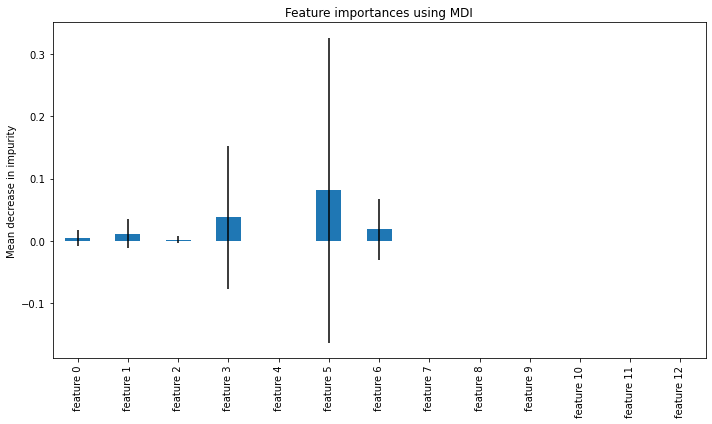

In [48]:
#plot important features for MFCC [0-12]
feature_names = [f'feature {i}' for i in range(X.shape[1])]
importances = regressor.feature_importances_

std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

forest_importances = pd.Series(importances[:13], index=feature_names[:13])

fig, ax = plt.subplots(figsize=(10,6))
forest_importances.plot.bar(yerr=std[:13], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**It appears that MFCC Coeffieient Number 2, 4 and 6 are important**

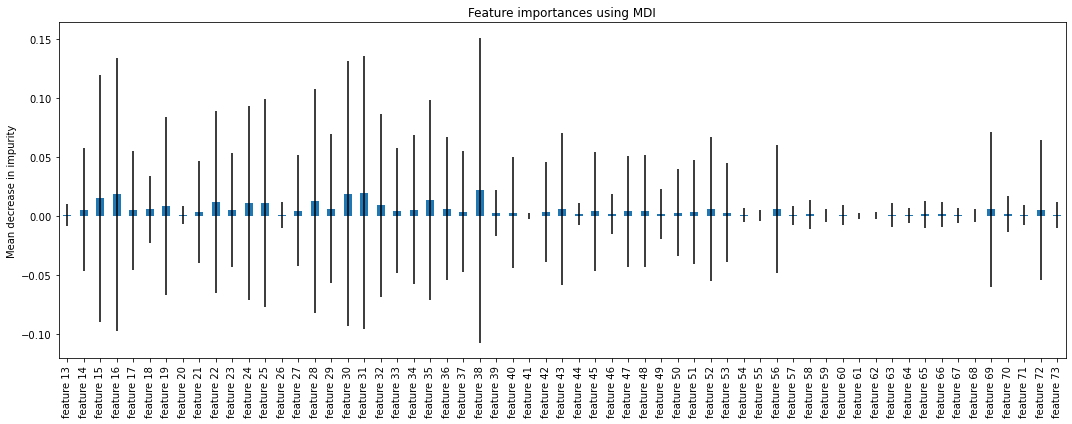

In [20]:
#plot important features for MelSpectogram [13-141]
feature_names = [f'feature {i}' for i in range(X.shape[1])]
importances = regressor.feature_importances_

std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

#realised that features beyond mel-band number 60 are anyway not important. Hence, we plot mel-band from 0 to 60
forest_importances = pd.Series(importances[13:74], index=feature_names[13:74])

fig, ax = plt.subplots(figsize=(15,6))
forest_importances.plot.bar(yerr=std[13:74], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=90)
fig.tight_layout()

**It appears that Mel band of 9, 30, 39 and 43 are important**

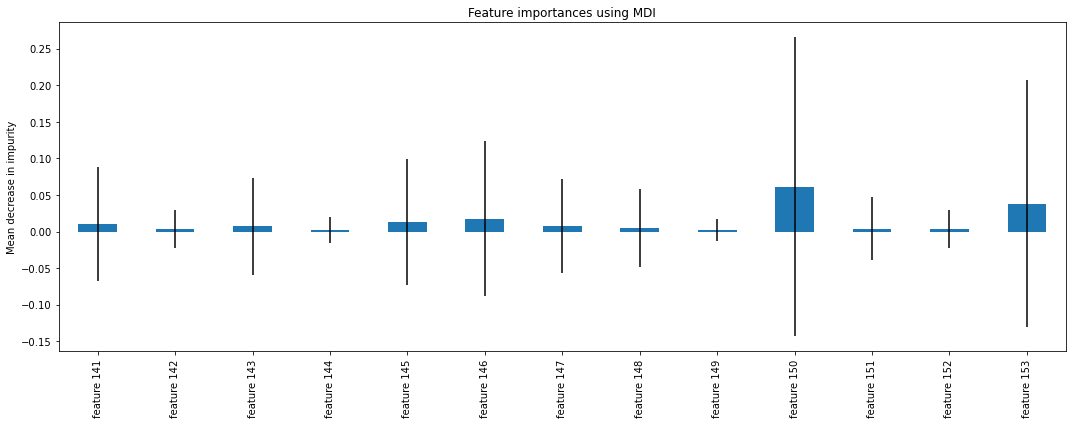

In [21]:
#plot important features for Chromagram  [151-154] (also includes the last feature which is approximate value of lung param)

feature_names = [f'feature {i}' for i in range(X.shape[1])]
importances = regressor.feature_importances_

std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

#realised that features beyond mel-band number 60 are anyway not important. Hence, we plot mel-band from 0 to 60
forest_importances = pd.Series(importances[141:154], index=feature_names[141:154])

fig, ax = plt.subplots(figsize=(15,6))
forest_importances.plot.bar(yerr=std[141:154], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=90)
fig.tight_layout()

**It appears Chromagram Coeffieient 5,10 and 13 are important**

Lets Plot the observed result

C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


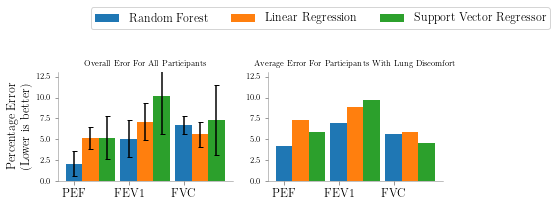

In [7]:
# plots to be manullly made using results from sheet
#N95 Mask

rf_pe= [2.1,5.1,6.7]
lr_pe = [5.2,7.1,5.6]
svr_pe = [5.2,10.2,7.3]

rf_std= [1.5,2.2,1.1]
lr_std = [1.3,2.2,1.5]
svr_std = [2.6,4.5,4.2]

rf_pe_u= [4.2,7,5.65]
lr_pe_u = [7.3,8.85,5.85]
svr_pe_u = [5.85,9.75,4.55]


figname = 'revised-overall-error-n95'
lt.latexify(columns=2, fig_height=2)
labels = ['PEF', 'FEV1', 'FVC']


x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(1,2)

rects1 = ax[0].bar(x, rf_pe, width, label='Random Forest', yerr=rf_std, ecolor='black', capsize=2.5, align='center')
rects2 = ax[0].bar(x + width, lr_pe, width, label='Linear Regression', yerr=lr_std, ecolor='black', capsize=2.5, align='center')
rects3 = ax[0].bar(x + width*2, svr_pe, width, label='Support Vector Regressor', yerr=svr_std, ecolor='black', capsize=2.5, align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_title("Overall Eror For All Participants")
ax[0].set_ylabel('Percentage Error\n (Lower is better)',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, fontsize=12)
ax[0].set_ylim(0,13)
#ax[0].annotate(' Result For N95 Mask',xy=(0, 0), xytext=(60, 190),xycoords=('axes fraction', 'axes fraction'),textcoords='offset points',size=14, ha='center', va='bottom', weight='bold')
#ax[0].legend(bbox_to_anchor=[0.55,1.2],ncol=3, fontsize=12, loc='center')
lt.format_axes(ax[0])

rects1 = ax[1].bar(x, rf_pe_u, width, label='Random Forest', ecolor='black', capsize=2.5, align='center')
rects2 = ax[1].bar(x + width, lr_pe_u, width, label='Linear Regression', ecolor='black', capsize=2.5, align='center')
rects3 = ax[1].bar(x + width*2, svr_pe_u, width, label='Support Vector Regressor', ecolor='black', capsize=2.5, align='center')
ax[1].set_title("Average Error For Participants With Lung Discomfort")
#ax[1].set_ylabel('Percentage Error',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize=12)
ax[1].set_ylim(0,13)
ax[1].legend(bbox_to_anchor=[0.3,1.5],ncol=3, fontsize=12, loc='center')
lt.format_axes(ax[1])




#fig.tight_layout()




plt.savefig(figname+'.pdf', bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


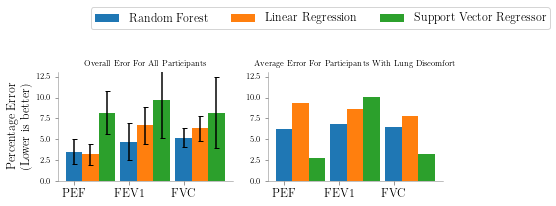

In [8]:
# plots to be manullly made using results from sheet
#Cloth Mask

rf_pe= [3.5,4.7,5.2]
lr_pe = [3.2,6.7,6.3]
svr_pe = [8.2,9.7,8.2]

rf_std= [1.5,2.2,1.1]
lr_std = [1.3,2.2,1.5]
svr_std = [2.6,4.5,4.2]

rf_pe_u= [6.2,6.8,6.5]
lr_pe_u = [9.3,8.6,7.8]
svr_pe_u = [2.8,10.1,3.21]


figname = 'revised-overall-error-cloth'
lt.latexify(columns=2, fig_height=2)
labels = ['PEF', 'FEV1', 'FVC']


x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(1,2)

rects1 = ax[0].bar(x, rf_pe, width, label='Random Forest', yerr=rf_std, ecolor='black', capsize=2.5, align='center')
rects2 = ax[0].bar(x + width, lr_pe, width, label='Linear Regression', yerr=lr_std, ecolor='black', capsize=2.5, align='center')
rects3 = ax[0].bar(x + width*2, svr_pe, width, label='Support Vector Regressor', yerr=svr_std, ecolor='black', capsize=2.5, align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_title("Overall Eror For All Participants")
ax[0].set_ylabel('Percentage Error\n (Lower is better)',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, fontsize=12)
ax[0].set_ylim(0,13)
#ax[0].legend(bbox_to_anchor=[0.55,1.2],ncol=3, fontsize=12, loc='center')
#ax[0].annotate(' Result For Cloth Mask',xy=(0, 0), xytext=(60, 190),xycoords=('axes fraction', 'axes fraction'),textcoords='offset points',size=14, ha='center', va='bottom', weight='bold')
lt.format_axes(ax[0])

rects1 = ax[1].bar(x, rf_pe_u, width, label='Random Forest', ecolor='black', capsize=2.5, align='center')
rects2 = ax[1].bar(x + width, lr_pe_u, width, label='Linear Regression', ecolor='black', capsize=2.5, align='center')
rects3 = ax[1].bar(x + width*2, svr_pe_u, width, label='Support Vector Regressor', ecolor='black', capsize=2.5, align='center')
ax[1].set_title("Average Error For Participants With Lung Discomfort")
#ax[1].set_ylabel('Percentage Error',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize=12)
ax[1].set_ylim(0,13)
ax[1].legend(bbox_to_anchor=[0.3,1.5],ncol=3, fontsize=12, loc='center')
lt.format_axes(ax[1])




#fig.tight_layout()




plt.savefig(figname+'.pdf', bbox_inches='tight')